### 5.5.2 사인 곡선 예측에 대한 전체 코드

In [1]:
import numpy as np
# import cupy as np  # GPU를 사용하면 주석 해제
import matplotlib.pyplot as plt

# -- 각 설정값 --
n_time = 10  # 시점의 수(2진수의 자릿수)
n_in = 1  # 입력층 뉴런의 수
n_mid = 20  # 은닉층 뉴런의 수
n_out = 1  # 출력층 뉴런의 수


eta = 0.01  # 학습률
epochs = 101
batch_size = 8
interval = 10  # # 경과 표시 간격


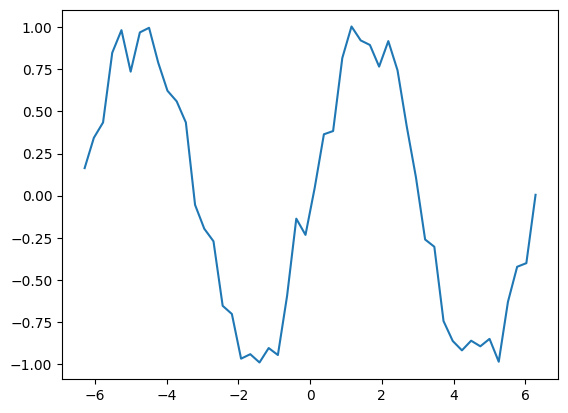

(40, 10, 1)
(40, 1)


In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

# -- 훈련 데이터 생성 --
sin_x = np.linspace(-2*np.pi, 2*np.pi)  # # -2π에서 2π까지
sin_y = np.sin(sin_x)  + 0.1*np.random.randn(len(sin_x))  # # sin 함수에 무작위로 노이즈 섞기
plt.plot(sin_x,sin_y)
plt.show()

n_sample = len(sin_x)-n_time  # 샘플 수
input_data = np.zeros((n_sample, n_time, n_in))  # 입력
correct_data = np.zeros((n_sample, n_out))  # 정답
for i in range(0, n_sample):
    input_data[i] = sin_y[i:i+n_time].reshape(-1, 1)
    correct_data[i] = sin_y[i+n_time:i+n_time+1]  # 정답은 입력보다 한 시점 후
print(np.array(input_data).shape)
print(np.array(correct_data).shape)

In [3]:
# -- LSTM층 -- 
class LSTMLayer:
    def __init__(self, n_upper, n):
        # 각 파라미터의 초깃값
        self.w = np.random.randn(4, n_upper, n) / np.sqrt(n_upper)  # 자비에르 기반의 초깃값
        self.v = np.random.randn(4, n, n) / np.sqrt(n)
        self.b = np.zeros((4, n))

    def forward(self, x, y_prev, c_prev):  # y_prev, c_prev: 이전 시점의 출력과 기억 셀
        u = np.matmul(x, self.w) + np.matmul(y_prev, self.v) + self.b.reshape(4, 1, -1)

        a0 = sigmoid(u[0])  # 망각 게이트
        a1 = sigmoid(u[1])  # 입력 게이트
        a2 = np.tanh(u[2])  # 새로운 기억
        a3 = sigmoid(u[3])  # 출력 게이트
        self.gates = np.stack((a0, a1, a2, a3))

        self.c = a0*c_prev + a1*a2  # 기억 셀
        self.y = a3 * np.tanh(self.c)  # 출력

    
    def backward(self, x, y, c, y_prev, c_prev, gates, grad_y, grad_c):   
        a0, a1, a2, a3 = gates
        tanh_c = np.tanh(c)
        r = grad_c + (grad_y*a3) * (1-tanh_c**2)

        # 각 delta
        delta_a0 = r * c_prev * a0 * (1-a0)
        delta_a1 = r * a2 * a1 * (1-a1)
        delta_a2 = r * a1 * (1 - a2**2)
        delta_a3 = grad_y * tanh_c * a3 * (1 - a3)

        deltas = np.stack((delta_a0, delta_a1, delta_a2, delta_a3))

        # 各 파라미터의 기울기
        self.grad_w += np.matmul(x.T, deltas)
        self.grad_v += np.matmul(y_prev.T, deltas)
        self.grad_b += np.sum(deltas, axis=1)

        # x 기울기
        grad_x = np.matmul(deltas, self.w.transpose(0, 2, 1))
        self.grad_x = np.sum(grad_x, axis=0)

        # y_prev 기울기
        grad_y_prev = np.matmul(deltas, self.v.transpose(0, 2, 1))
        self.grad_y_prev = np.sum(grad_y_prev, axis=0)
        
        # c_prev 기울기
        self.grad_c_prev = r * a0

    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)
        self.grad_b = np.zeros_like(self.b)

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v
        self.b -= eta * self.grad_b


In [4]:

# -- 전결합 출력층 --
class OutputLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)  # 자비에르 초기화 기반의 초깃값
        self.b = np.zeros(n)

    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u  # 항등함수

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T) 

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b


In [5]:

# -- 각 층의 초기화 --
lstm_layer = LSTMLayer(n_in, n_mid)
output_layer = OutputLayer(n_mid, n_out)


In [6]:

# -- 훈련 --
def train(x_mb, t_mb):
    # 순전파 LSTM층
    y_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    c_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    gates_rnn = np.zeros((4, len(x_mb), n_time, n_mid))
    y_prev = y_rnn[:, 0, :]
    c_prev = c_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        lstm_layer.forward(x, y_prev, c_prev)

        y = lstm_layer.y
        y_rnn[:, i+1, :] = y
        y_prev = y

        c = lstm_layer.c
        c_rnn[:, i+1, :] = c
        c_prev = c

        gates = lstm_layer.gates
        gates_rnn[:, :, i, :] = gates

    # 순전파 출력층
    output_layer.forward(y)

    # 역전파 출력층
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x
    grad_c = np.zeros_like(lstm_layer.c)

    # 순전파 LSTM층
    lstm_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:, i+1, :]
        c = c_rnn[:, i+1, :]
        y_prev = y_rnn[:, i, :]
        c_prev = c_rnn[:, i, :]
        gates = gates_rnn[:, :, i, :] 

        lstm_layer.backward(x, y, c, y_prev, c_prev, gates, grad_y, grad_c)
        grad_y = lstm_layer.grad_y_prev
        grad_c = lstm_layer.grad_c_prev

    # 파라미터 갱신
    lstm_layer.update(eta)
    output_layer.update(eta)


In [7]:

# -- 예측 --
def predict(x_mb):
    # 순전파 LSTM층
    y_prev = np.zeros((len(x_mb), n_mid))
    c_prev = np.zeros((len(x_mb), n_mid))
    for i in range(n_time):
        x = x_mb[:, i, :]
        lstm_layer.forward(x, y_prev, c_prev)
        y = lstm_layer.y
        y_prev = y
        c = lstm_layer.c
        c_prev = c
    
    # 순전파 출력층
    output_layer.forward(y)
    return output_layer.y

# -- 오차 계산 --
def get_error(x, t):
    y = predict(x)
    return 1.0/2.0*np.sum(np.square(y - t))  # 오차제곱합


Epoch:1/101 Error:5.2837523229707335
p1 [0.16338155 0.34326918 0.4345333  0.84893979 0.98293626 0.73651949
 0.96962393 0.99700756 0.78898374 0.62300955]


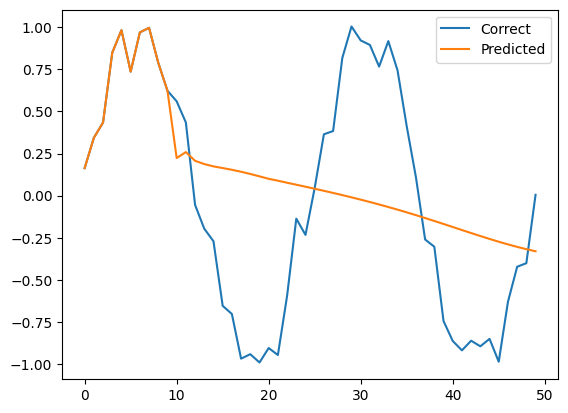

Epoch:11/101 Error:2.3294528507017462
p1 [0.16338155 0.34326918 0.4345333  0.84893979 0.98293626 0.73651949
 0.96962393 0.99700756 0.78898374 0.62300955]


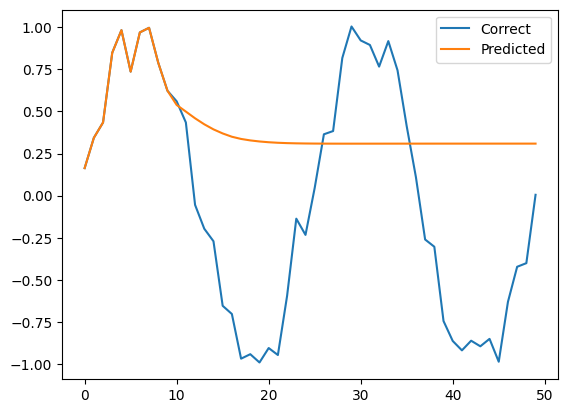

Epoch:21/101 Error:1.482387103671725
p1 [0.16338155 0.34326918 0.4345333  0.84893979 0.98293626 0.73651949
 0.96962393 0.99700756 0.78898374 0.62300955]


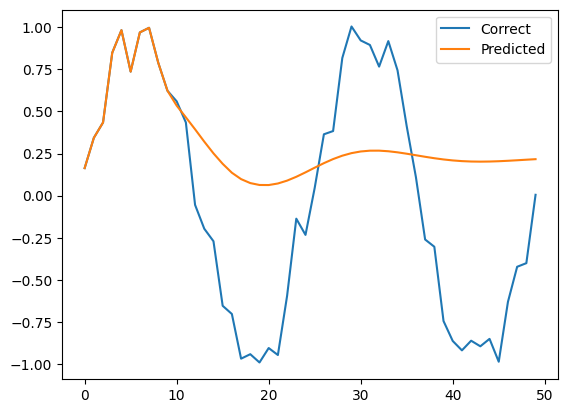

Epoch:31/101 Error:0.9791234116896689
p1 [0.16338155 0.34326918 0.4345333  0.84893979 0.98293626 0.73651949
 0.96962393 0.99700756 0.78898374 0.62300955]


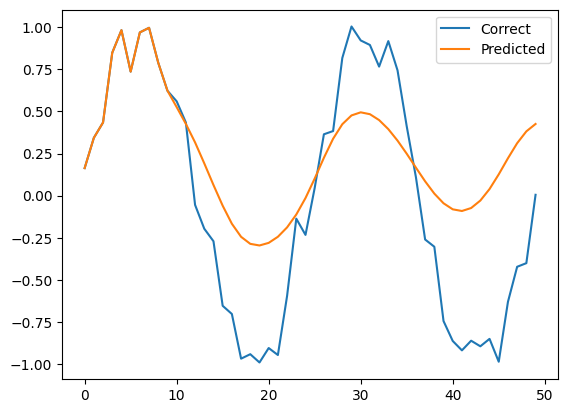

Epoch:41/101 Error:0.7148138922331968
p1 [0.16338155 0.34326918 0.4345333  0.84893979 0.98293626 0.73651949
 0.96962393 0.99700756 0.78898374 0.62300955]


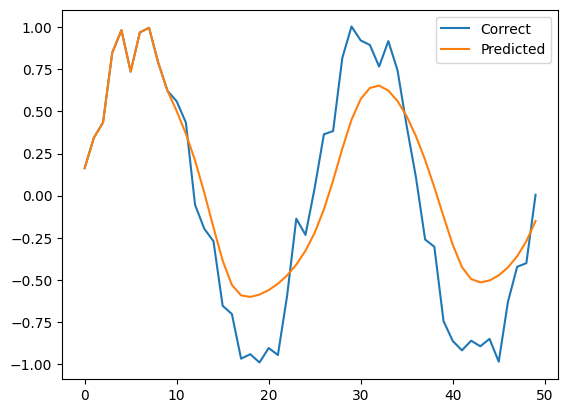

Epoch:51/101 Error:0.5978070181485022
p1 [0.16338155 0.34326918 0.4345333  0.84893979 0.98293626 0.73651949
 0.96962393 0.99700756 0.78898374 0.62300955]


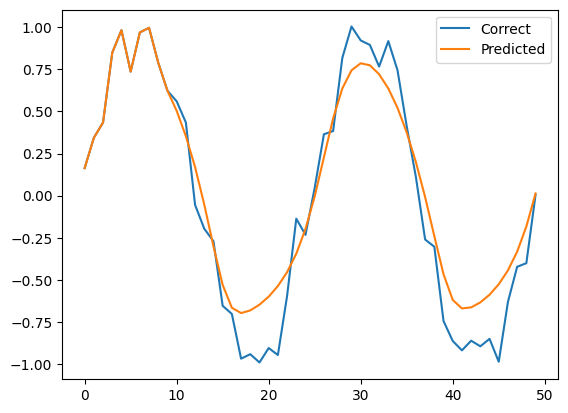

Epoch:61/101 Error:0.5460071716290327
p1 [0.16338155 0.34326918 0.4345333  0.84893979 0.98293626 0.73651949
 0.96962393 0.99700756 0.78898374 0.62300955]


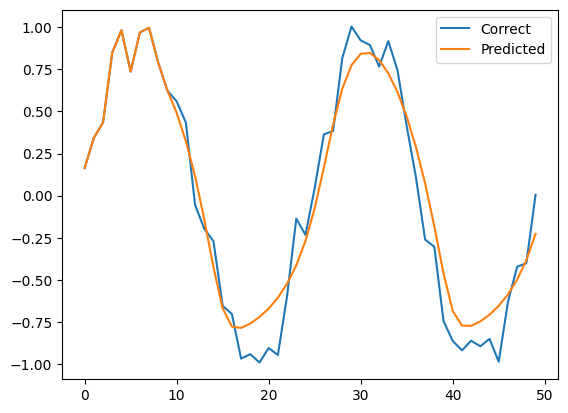

Epoch:71/101 Error:0.5209015923211574
p1 [0.16338155 0.34326918 0.4345333  0.84893979 0.98293626 0.73651949
 0.96962393 0.99700756 0.78898374 0.62300955]


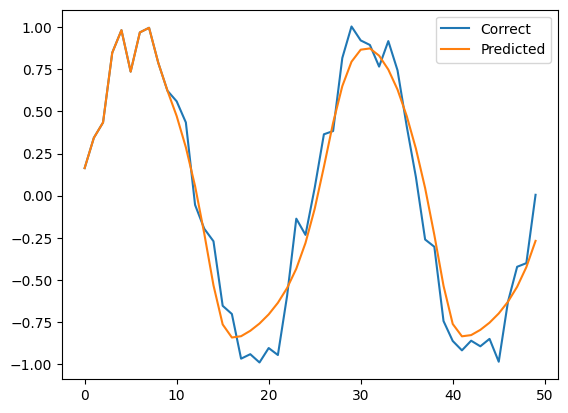

Epoch:81/101 Error:0.5026471094072398
p1 [0.16338155 0.34326918 0.4345333  0.84893979 0.98293626 0.73651949
 0.96962393 0.99700756 0.78898374 0.62300955]


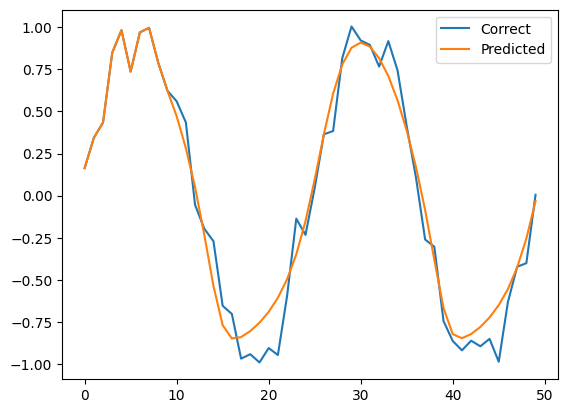

Epoch:91/101 Error:0.4888122747383098
p1 [0.16338155 0.34326918 0.4345333  0.84893979 0.98293626 0.73651949
 0.96962393 0.99700756 0.78898374 0.62300955]


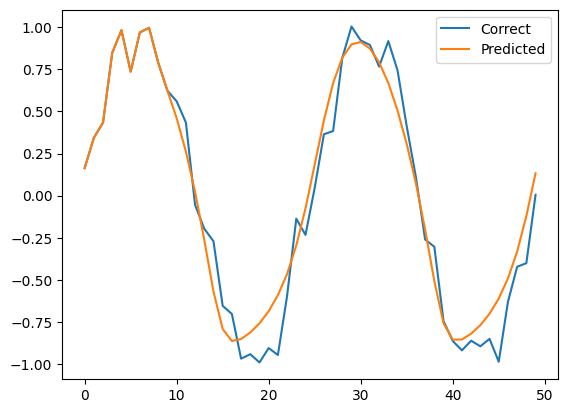

Epoch:101/101 Error:0.476306466039242
p1 [0.16338155 0.34326918 0.4345333  0.84893979 0.98293626 0.73651949
 0.96962393 0.99700756 0.78898374 0.62300955]


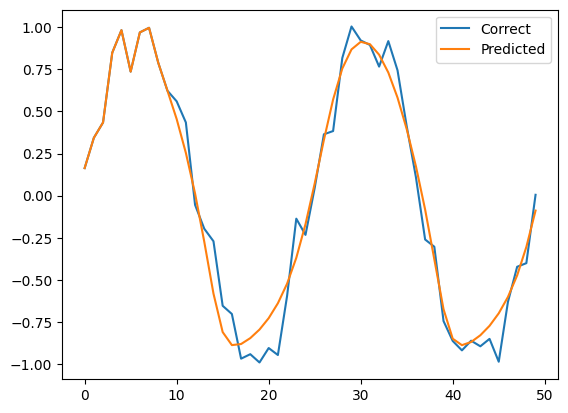

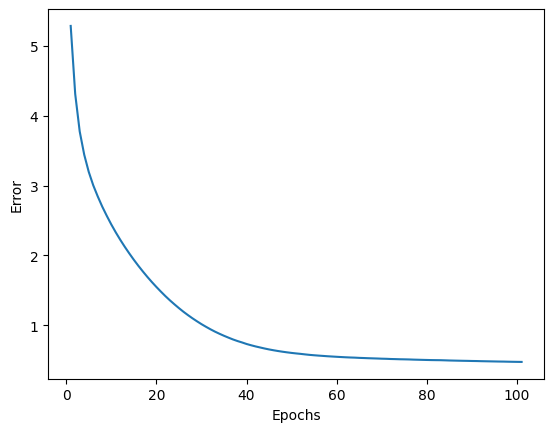

In [8]:

error_record = []
n_batch = len(input_data) // batch_size  #  # 1에포크당 배치 개수
for i in range(epochs):
        
    # -- 학습 -- 
    index_random = np.arange(len(input_data))
    np.random.shuffle(index_random)  # 인덱스 임의 섞기
    for j in range(n_batch):
        
       # 미니 배치 구성
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = input_data[mb_index, :]
        t_mb = correct_data[mb_index, :]
        train(x_mb, t_mb)

   # -- 오차 계산 --
    error = get_error(input_data, correct_data)
    error_record.append(error)

     # -- 경과 표시 --
    if i%interval == 0: # tarin을 n_batch x interval번 할 때마다 predict로 예측
        print("Epoch:"+str(i+1)+"/"+str(epochs), "Error:"+str(error))

        predicted = input_data[0].reshape(-1).tolist() # 최초입력 처음 n_time(10개)합친거
        print("p1",np.array(predicted))
        for i in range(n_sample): #남은 40개 추가
            x = np.array(predicted[-n_time:]).reshape(1, n_time, 1)# 마지막 10개로 예측
            #print("x\n-----------\n",np.array(x))
            y = predict(x)
            predicted.append(float(y[0, 0]))  # # 출력을 predicted에 추가
        #print("p",np.array(predicted))    
        plt.plot(range(len(sin_y)), sin_y.tolist(), label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()
    #break
plt.plot(range(1, len(error_record)+1), error_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()